In [11]:
import dagshub

# Initialize DagsHub's MLflow tracking with your repository credentials
dagshub.init(repo_owner='Omdena', repo_name='MyanmarChapter_MicroGridOptimization', mlflow=True)


Accessing as nino.godoradze

Initialized MLflow to track repo "Omdena/MyanmarChapter_MicroGridOptimization"

Repository Omdena/MyanmarChapter_MicroGridOptimization initialized!

In [2]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from prophet import Prophet

c:\Users\Nino\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
data=pd.read_csv(r'C:\Users\Nino\Desktop\My Files\Omdena Project\data\processed\Bago_Bago_pv_weather_merged.csv')

In [4]:
data =data[['date', 'time','electricity']]
data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'])

In [5]:
data_train=data[data['date'] <='2022-09-01']
data_oot=data[data['date'] >'2022-09-01']

In [13]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from prophet import Prophet
import mlflow
import mlflow.pyfunc

# Set up MLflow tracking
mlflow.set_experiment("Prophet Model Forecasting")

# Prepare the training data for Prophet
data_train = data_train.rename(columns={'datetime': 'ds', 'electricity': 'y'})

# Shift the 'y' column by 24 hours to create the next 24-hour prediction column
data_train['y_next_24h'] = data_train['y'].shift(-24)

# Drop rows where 'y_next_24h' is NaN
data_train = data_train.dropna(subset=['y_next_24h'])

# Start an MLflow run to track this model
with mlflow.start_run(run_name="Prophet Model with 24-Hour Forecast") as run:
    
    # Define hyperparameters for the Prophet model
    daily_seasonality = True
    weekly_seasonality = True
    yearly_seasonality = True

    # Log the hyperparameters in MLflow
    mlflow.log_param("daily_seasonality", daily_seasonality)
    mlflow.log_param("weekly_seasonality", weekly_seasonality)
    mlflow.log_param("yearly_seasonality", yearly_seasonality)

    # Initialize and fit the Prophet model
    model = Prophet(daily_seasonality=daily_seasonality, 
                    weekly_seasonality=weekly_seasonality, 
                    yearly_seasonality=yearly_seasonality)
    model.fit(data_train[['ds', 'y']])

    # Create a dataframe for future predictions (for the next 24 hours)
    future_df = data_train[['ds']].copy()
    future_df['ds'] = future_df['ds'] + pd.Timedelta(hours=24)

    # Make predictions for 24 hours ahead
    forecast = model.predict(future_df)

    # Join the forecasted 'yhat' values with the actual 'y_next_24h' values
    forecast = forecast[['ds', 'yhat']].merge(data_train[['ds', 'y_next_24h']], on='ds')

    # Calculate evaluation metrics
    y_true = forecast['y_next_24h'].values
    y_pred = forecast['yhat'].values

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Log metrics in MLflow
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("R2", r2)  # Fixed metric name

    # Log the Prophet model in MLflow
    mlflow.prophet.log_model(model, artifact_path="prophet-model")

    # Print evaluation metrics to console for verification
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'R2: {r2:.4f}')

# End of MLflow run


00:16:16 - cmdstanpy - INFO - Chain [1] start processing
00:16:17 - cmdstanpy - INFO - Chain [1] done processing
2024/09/29 00:16:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RMSE: 0.0669
MAE: 0.0488
R2: 0.9176


2024/09/29 00:16:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run Prophet Model with 24-Hour Forecast at: https://dagshub.com/Omdena/MyanmarChapter_MicroGridOptimization.mlflow/#/experiments/1/runs/b3840593b2644c8b841ec27dcb162881.
2024/09/29 00:16:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Omdena/MyanmarChapter_MicroGridOptimization.mlflow/#/experiments/1.


In [6]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from prophet import Prophet

# Prepare the training data for Prophet
data_train = data_train.rename(columns={'datetime': 'ds', 'electricity': 'y'})

data_train['y_next_24h'] = data_train['y'].shift(-24)

# Drop the rows where 'y_next_24h' is NaN (because we can't predict beyond the available data)
data_train = data_train.dropna(subset=['y_next_24h'])

# Initialize and fit the Prophet model on the original 'y' values
model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
model.fit(data_train[['ds', 'y']])

# Create a dataframe for future predictions (we want to predict 24 hours ahead for each row)
# The model will now predict for the time 'ds + 24 hours'
future_df = data_train[['ds']].copy()
future_df['ds'] = future_df['ds'] + pd.Timedelta(hours=24)

# Make predictions for 24 hours ahead
forecast = model.predict(future_df)

# Join the forecasted 'yhat' values with the actual 'y_next_24h' values from data_train
forecast = forecast[['ds', 'yhat']].merge(data_train[['ds', 'y_next_24h']], on='ds')

# Calculate evaluation metrics
y_true = forecast['y_next_24h'].values
y_pred = forecast['yhat'].values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
r2 = r2_score(y_true, y_pred)

# Print the evaluation metrics
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R^2: {r2:.4f}')


23:52:59 - cmdstanpy - INFO - Chain [1] start processing
23:53:00 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.0668
MAE: 0.0487
R^2: 0.9178


C:\Users\Nino\AppData\Local\Temp\ipykernel_1372\3613018596.py:35: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error


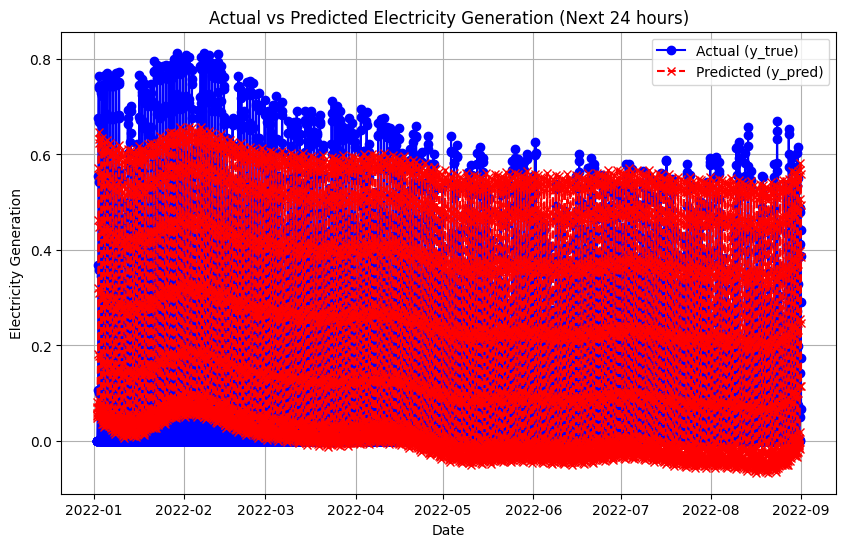

In [7]:
import matplotlib.pyplot as plt

# Plot y_true and y_pred
plt.figure(figsize=(10, 6))
plt.plot(forecast['ds'], y_true, label='Actual (y_true)', color='blue', marker='o')
plt.plot(forecast['ds'], y_pred, label='Predicted (y_pred)', color='red', linestyle='--', marker='x')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Electricity Generation')
plt.title('Actual vs Predicted Electricity Generation (Next 24 hours)')
plt.legend()

# Show plot
plt.grid(True)
plt.show()


RMSE (OOT): 0.1283
MAE (OOT): 0.1041
R^2 (OOT): 0.7247


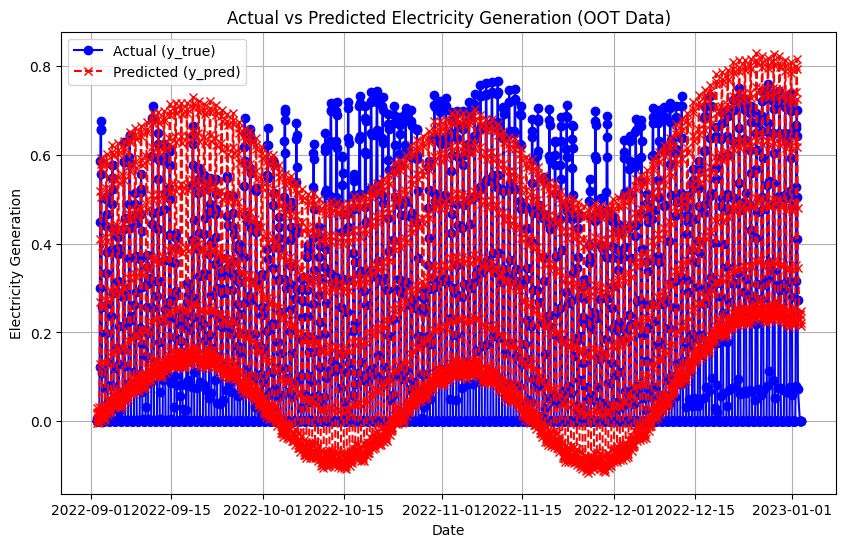

In [10]:
# Prepare the OOT data (ensure it has 'ds' and 'y' columns)
data_oot = data_oot.rename(columns={'datetime': 'ds', 'electricity': 'y'})

# Use the trained model to predict on OOT data
forecast_oot = model.predict(data_oot[['ds']])

# Join the forecasted 'yhat' values with the actual 'y' values from data_oot
forecast_oot = forecast_oot[['ds', 'yhat']].merge(data_oot[['ds', 'y']], on='ds')

# Calculate evaluation metrics on OOT data
y_true_oot = forecast_oot['y'].values
y_pred_oot = forecast_oot['yhat'].values

rmse_oot = np.sqrt(mean_squared_error(y_true_oot, y_pred_oot))
mae_oot = mean_absolute_error(y_true_oot, y_pred_oot)
r2_oot = r2_score(y_true_oot, y_pred_oot)

# Print evaluation metrics for OOT data
print(f'RMSE (OOT): {rmse_oot:.4f}')
print(f'MAE (OOT): {mae_oot:.4f}')
print(f'R^2 (OOT): {r2_oot:.4f}')

# Plot actual vs predicted values for OOT data
plt.figure(figsize=(10, 6))
plt.plot(forecast_oot['ds'], y_true_oot, label='Actual (y_true)', color='blue', marker='o')
plt.plot(forecast_oot['ds'], y_pred_oot, label='Predicted (y_pred)', color='red', linestyle='--', marker='x')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Electricity Generation')
plt.title('Actual vs Predicted Electricity Generation (OOT Data)')
plt.legend()

# Show plot
plt.grid(True)
plt.show()
